# 基于RFM 模型的 Python 实战分析


一、RFM 模型介绍

RFM模型是根据客户活跃程度和交易金额的贡献，进行客户价值细分的一种用户分类方法。

    R（Recency）——最近一次交易时间间隔。基于最近一次交易日期计算的得分，距离当前日期越近，得分越高。如5分制反映客户交易活跃度较高。
    F（Frequency）——客户在最近一段时间内交易次数。基于交易频率计算的得分，交易频率越高，得分越高。如5分制反映客户交易频次较高。
    M（Monetray）——客户最近一段时间内交易金额。基于交易金额计算的得分，交易金额越高，得分越高。如5分制反映客户交易金额较高。

以上三个指标对客户进行 每个维度的1-5 分打分，会将每个维度细分出5类，这样就能够细分出共5x5x5=125类用户。

但一般来说125类用户已超出普通人脑的计算范畴了，更别说针对125类用户量体定制营销策略。

在本次实战中，我们只把每个维度做一次两分，即在每个维度上取平均值，高于平均值取 1，低于平均值取 0。

这样在3个维度上我们得到了2* 2*2=8类用户。
 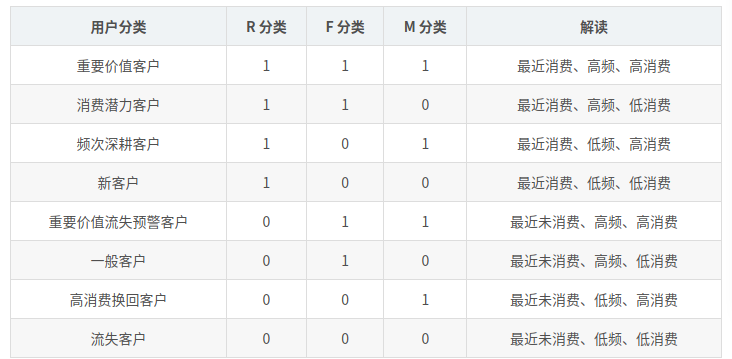
基于这 8 类用户，我们再进行用户营销策略制定，显而易见会容易许多。

二、数据导入
1.相关包导入

先对相关包进行导入，将数据导入 Python：

In [189]:
import pandas as pd
import numpy as np
import numpy as np
df=pd.read_csv('RMF_Data_Clean-1.csv')

In [190]:
df.columns

Index(['Unnamed: 0', '乘客编号', '订单金额', '叫车时间'], dtype='object')

三、RFM 模型建立：

构建模型所需的三个字段：

In [191]:
r=df.groupby('乘客编号')['叫车时间'].max().reset_index()
#获得每一位乘客的最近一次叫车时间
r.head()

,乘客编号,叫车时间
0,15307,2020/2/25 10:20
1,45057,2020/2/9 6:42
2,174506,2020/2/29 8:06
3,200870,2020/2/17 18:23
4,368221,2020/2/8 22:58


再以获取数据的时间（2020/3/1）减去叫车时间，即为R：



In [192]:
r['R']=((pd.to_datetime('2020/3/1')-pd.to_datetime(r['叫车时间']))).dt.days

In [193]:
r=r[['乘客编号','R']]

In [194]:
r.head()

,乘客编号,R
0,15307,4
1,45057,20
2,174506,0
3,200870,12
4,368221,21


2、F 字段的构造

由于叫车时间为年月日时分秒的格式，故我们要先获得一个日期标签：



In [195]:
df['日期标签']=pd.to_datetime(df['叫车时间']).dt.date
df.head()

,Unnamed: 0,乘客编号,订单金额,叫车时间,日期标签
0,0,210435946,14.49,2020/2/29 17:26,2020-02-29
1,1,907820914,22.98,2020/2/29 17:25,2020-02-29
2,2,11703871,21.09,2020/2/29 17:24,2020-02-29
3,3,938325219,25.98,2020/2/29 17:23,2020-02-29
4,4,212530389,23.76,2020/2/29 17:21,2020-02-29


一般建立 RFM 模型时，我们会将客户一天内的多笔订单视为一笔

即将以乘客编号&日期标签作聚合，获得各个乘客在 每一天的打车频次：

In [196]:
df_1=df.groupby(['乘客编号','日期标签'])['叫车时间'].count().reset_index()
df_1.head(10)


,乘客编号,日期标签,叫车时间
0,15307,2020-02-14,1
1,15307,2020-02-16,1
2,15307,2020-02-23,1
3,15307,2020-02-25,1
4,45057,2020-02-09,1
5,174506,2020-02-02,2
6,174506,2020-02-10,1
7,174506,2020-02-12,1
8,174506,2020-02-18,2
9,174506,2020-02-19,1


再以乘客编号作聚合，获得乘客在 2 月当月的打车天数：

In [197]:
f=df_1.groupby('乘客编号')['日期标签'].count().reset_index()
f.columns=['乘客编号','F']
f.head()

,乘客编号,F
0,15307,4
1,45057,1
2,174506,11
3,200870,1
4,368221,1


3、M 字段的构造：

M（平均下单金额）= 乘客总下单金额 / F（购买频次）

In [198]:
sum_m=df.groupby('乘客编号')['订单金额'].sum().reset_index()
sum_m.columns=['乘客编号','2月总支付金额']
sum_m.head()


,乘客编号,2月总支付金额
0,15307,95.16
1,45057,654.62
2,174506,299.77
3,200870,51.30
4,368221,106.60


以乘客编号为依据对频次表和总金额表进行表连接：

In [199]:
sum_to_f=pd.merge(sum_m,f,left_on='乘客编号',right_on='乘客编号',how='inner')
sum_to_f.head()


,乘客编号,2月总支付金额,F
0,15307,95.16,4
1,45057,654.62,1
2,174506,299.77,11
3,200870,51.30,1
4,368221,106.60,1


计算用户平均每天的打车金额：

In [200]:
sum_to_f['M']=sum_to_f['2月总支付金额']/sum_to_f['F']
sum_to_f.head()

,乘客编号,2月总支付金额,F,M
0,15307,95.16,4,23.790000
1,45057,654.62,1,654.620000
2,174506,299.77,11,27.251818
3,200870,51.30,1,51.300000
4,368221,106.60,1,106.600000


4、组合R/F/M 字段：

依旧使用 Pandas 的表连接功能：



In [201]:
#将 RFM 三个指标进行合并
rfm=pd.merge(r,sum_to_f,left_on='乘客编号',right_on='乘客编号',how='inner')
rfm=rfm[['乘客编号','R','F','M']]
rfm.head()


,乘客编号,R,F,M
0,15307,4,4,23.790000
1,45057,20,1,654.620000
2,174506,0,11,27.251818
3,200870,12,1,51.300000
4,368221,21,1,106.600000


5、维度打分：

经过上面的处理，我们已经获得每个乘客的R\F\M 值，但由于他们各自之间数值的差距仍旧较大，所以我们下一步要对上述 RFM 数值进行维度打分，一般情况下分为 1分-5 分；

在我们不知道怎么去获取维度指标，也就是数据分组时，可以先看下 RFM 的描述性统计量：

In [202]:
rfm.describe()


,乘客编号,R,F,M
count,9.885000e+03,9885.000000,9885.000000,9885.000000
mean,5.573309e+08,11.550228,2.580678,40.473768
std,3.488843e+08,9.165440,2.932722,24.962165
min,1.530700e+04,0.000000,1.000000,10.000000
25%,2.754259e+08,3.000000,1.000000,25.580000
50%,3.718384e+08,10.000000,1.000000,34.860000
75%,9.405680e+08,20.000000,3.000000,48.100000
max,9.999771e+08,29.000000,26.000000,654.620000


由上可知：

R（最近一次打车距今天数）：

    R 值的平均值为 11天：乘客最近一次打车距今平均已经 11天；

    R 值的最小值为  0 天：存在乘客在统计日当天下单；

    R 值的最大值为 29 天：按照2020 年 2 月有 29 天计算，有乘客自 2 月 1 日下单后再无下单行为；

    2 月所有下过单的用户中：25%的乘客在最近3天内有下单行为；

    2 月所有下过单的用户中：50%的乘客在最近10天内有下单行为；

    2 月所有下过单的用户中：75%的乘客在最近20天内有下单行为；

F（2月打车频次）:

    F 值的平均值为 2.58次：乘客平均 2月有 2.58天有下单行为 ；

    F 值的最小值为  1 天：乘客 2月下单天数最少为 1 天；

    F 值的最大值为 26 天：本月的29 天中最高有乘客有 26 天都有下单行为，可谓是忠实老客户；

    2 月所有下过单的用户中：25%的乘客都只在其中某一天下单；

    2 月所有下过单的用户中：50%的乘客都只在其中某一天下单；

    2 月所有下过单的用户中：75%的乘客下单天数都集中在在 3天或以下；


M（平均每日下单金额）：

	M 值的平均值为40.5元：所有乘客日均下单金额为 40.5 元 ；

    M 值的最小值为 10 元：乘客日均下单金额最小值为 10 元；

    M 值的最大值为 654 元：乘客日均下单金额最大值为 654元；

一般来说分值的大小决定偏好，分数越高，说明我们越喜欢该行为。

对于乘客最近一天乘车时间来说，R 越大，说明用户未下单时间越长，故应设置 R 越大，分值越小；
对于 F和 M 来说，乘客叫车频次越高、平均支付金额越大，说明乘客对平台的黏性越大，故这F\M 应设置为越大，分值越小；

RFM 模型中，一般打分采取五分制，按照对业务的理解，和上述描述性分析情况；

分值划分如下：
 

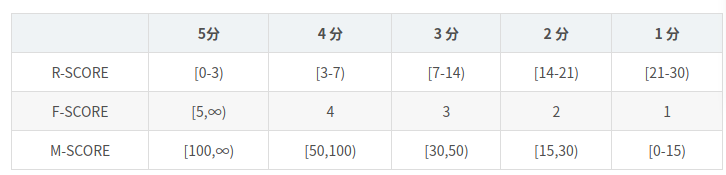

用 pandas 对数据进行分桶：

In [203]:
rfm['R-SCORE']=pd.cut(rfm['R'],bins=[0,3,7,14,21,30],labels=[5,4,3,2,1],right=False).astype(float)
rfm['F-SCORE']=pd.cut(rfm['F'],bins=[1,2,3,4,5,100],labels=[1,2,3,4,5],right=False).astype(float)
rfm['M-SCORE']=pd.cut(rfm['M'],bins=[0,15,30,50,100,10000],labels=[1,2,3,4,5],right=False).astype(float)

In [204]:
rfm.head()

,乘客编号,R,F,M,R-SCORE,F-SCORE,M-SCORE
0,15307,4,4,23.790000,4.0,4.0,2.0
1,45057,20,1,654.620000,2.0,1.0,5.0
2,174506,0,11,27.251818,5.0,5.0,2.0
3,200870,12,1,51.300000,3.0,1.0,4.0
4,368221,21,1,106.600000,1.0,1.0,5.0


6、用户标签获取

根据本文开头的分析：

    三个指标对客户进行 每个维度的1-5 分打分，会将每个维度细分出5类，这样就能够细分出共5x5x5=125类用户。

    但一般来说125类用户已超出普通人脑的计算范畴了，更别说针对125类用户量体定制营销策略。

    实际运用上，我们只需要把每个维度做一次两分即可，即在每个维度上取平均值，高于平均值取 1，低于平均值取 0；


故对每位乘客的 RFM分别对其平均值作分析，获得一个布尔值；

将该布尔值*1 可获得相应0 或 1 标签：


In [205]:
rfm['R是否大于平均值']=(rfm['R-SCORE']>rfm['R-SCORE'].mean())*1
rfm['F是否大于平均值']=(rfm['F-SCORE']>rfm['F-SCORE'].mean())*1
rfm['M是否大于平均值']=(rfm['M-SCORE']>rfm['M-SCORE'].mean())*1


In [206]:
rfm.head()

,乘客编号,R,F,M,R-SCORE,F-SCORE,M-SCORE,R是否大于平均值,F是否大于平均值,M是否大于平均值
0,15307,4,4,23.790000,4.0,4.0,2.0,1,1,0
1,45057,20,1,654.620000,2.0,1.0,5.0,0,0,1
2,174506,0,11,27.251818,5.0,5.0,2.0,1,1,0
3,200870,12,1,51.300000,3.0,1.0,4.0,0,0,1
4,368221,21,1,106.600000,1.0,1.0,5.0,0,0,1


将三项评价标准串联，获取人群数值打分项：

人群数值=R100+F10+M*1

In [207]:
rfm['数值标签']=(rfm['R是否大于平均值']*100+rfm['F是否大于平均值']*10+rfm['M是否大于平均值']*1)

In [208]:
rfm.head()

,乘客编号,R,F,M,R-SCORE,F-SCORE,M-SCORE,R是否大于平均值,F是否大于平均值,M是否大于平均值,数值标签
0,15307,4,4,23.790000,4.0,4.0,2.0,1,1,0,110
1,45057,20,1,654.620000,2.0,1.0,5.0,0,0,1,1
2,174506,0,11,27.251818,5.0,5.0,2.0,1,1,0,110
3,200870,12,1,51.300000,3.0,1.0,4.0,0,0,1,1
4,368221,21,1,106.600000,1.0,1.0,5.0,0,0,1,1


根据上述对值标签的名称定义：


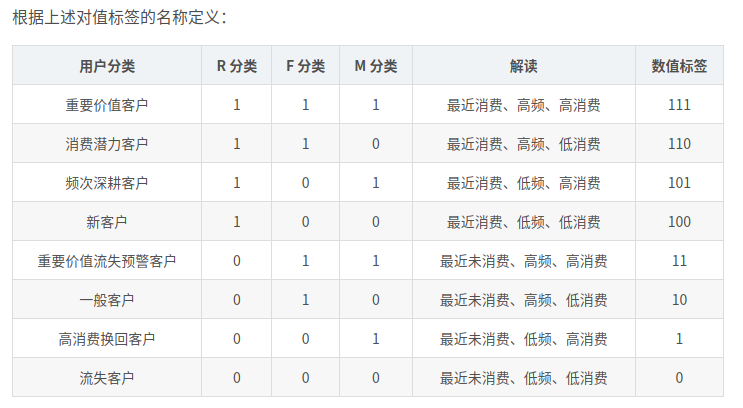

构造相应的转换标签函数：


In [209]:
def transform_label(s):
        if s==111:
            label='重要价值客户'
        elif s==110:
            label='消费潜力客户'
        elif s==101:
            label='频次深耕客户'
        elif s==100:
            label='新客户'
        elif s==11:
            label='重要价值流失预警客户'
        elif s==10:
            label='一般客户'
        elif s==1:
            label='高消费挽回客户'
        elif s==0:
            label='流失客户'
        return label
rfm['人群类型']=rfm['数值标签'].apply(transform_label) 

In [210]:
rfm.head()

,乘客编号,R,F,M,R-SCORE,F-SCORE,M-SCORE,R是否大于平均值,F是否大于平均值,M是否大于平均值,数值标签,人群类型
0,15307,4,4,23.790000,4.0,4.0,2.0,1,1,0,110,消费潜力客户
1,45057,20,1,654.620000,2.0,1.0,5.0,0,0,1,1,高消费挽回客户
2,174506,0,11,27.251818,5.0,5.0,2.0,1,1,0,110,消费潜力客户
3,200870,12,1,51.300000,3.0,1.0,4.0,0,0,1,1,高消费挽回客户
4,368221,21,1,106.600000,1.0,1.0,5.0,0,0,1,1,高消费挽回客户


至此，我们就完成了数据建模，每个用户都获得其相应的用户标签。

四、数据可视化


1、各用户群人数&占比分析：

以人群类型进行聚合：

In [211]:
count=rfm['人群类型'].value_counts().reset_index()
count.columns=['用户类型','人数']
count['人数占比']=count['人数']/count['人数'].sum()

获得 count 数据表如下：

In [212]:
count

,用户类型,人数,人数占比
0,高消费挽回客户,2615,0.264542
1,频次深耕客户,1711,0.173091
2,流失客户,1630,0.164896
3,新客户,1157,0.117046
4,重要价值流失预警客户,1032,0.104401
5,重要价值客户,892,0.090238
6,一般客户,471,0.047648
7,消费潜力客户,377,0.038139


可视化展示:不同类型用户人数分析

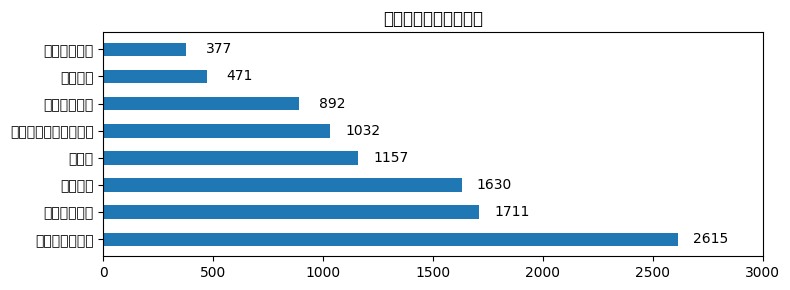

In [220]:
import matplotlib.pyplot as plt 
import matplotlib as mlp
                                    
plt.figure(figsize=(8,3),dpi=100)
y=count['人数']
x=count['用户类型']

plt.barh(x,height=0.5,width=y)
plt.title('不同类型用户人数对比')
for x,y in enumerate(y):
    plt.text(y+150,x,y,ha='center',va='center',fontsize=10)
plt.xticks(np.arange(0,3001,500))
plt.tight_layout()
plt.savefig('不同类型用户人数对比',dpi=300)

findfont: Font family ['Arial Unicode MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial Unicode MS'] not found. Falling back to DejaVu Sans.
/home/zheng/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21344 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zheng/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 21344 missing from current font.
  font.set_text(s, 0, flags=flags)


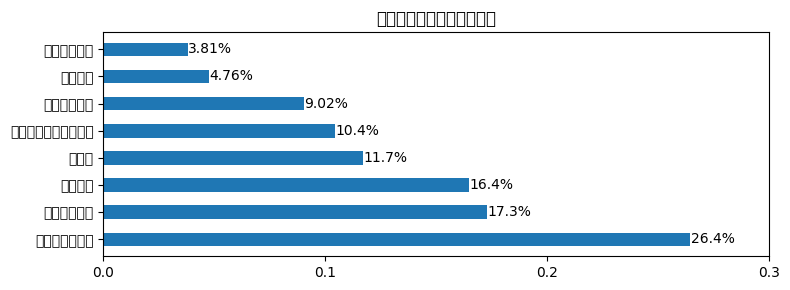

In [221]:
plt.rcParams['font.family']=['Arial Unicode MS']
plt.figure(figsize=(8,3),dpi=100)
y=count['人数占比']
x=count['用户类型']

plt.barh(x,height=0.5,width=y)
plt.title('不同类型用户人数占比对比')
for x,y in enumerate(y):
    plt.text(y+0.01,
             x,str(y*100)[:4]+'%',
             ha='center',va='center',
             fontsize=10)
plt.xticks(np.arange(0,0.4,0.1))
plt.tight_layout()
plt.savefig('不同类型用户人数占比对比',dpi=300)

由上图可知，所有用户类型中：

高消费挽回类客户人数最多，占比 25.7%。
其中高消费挽回类客户的定义为：最近未消费、低频、高消费。
对于此类用户的针对策略为发放大额门槛优惠券，如满50减8元优惠券等，来刺激用户消费积极性；

频次深耕用户+重要价值用户占比 33%，对于此类用户的针对策略为发放多张门槛优惠组合券包，如满 50 减 8 元+满 30 减 5 元+满20减 3 元等组合券包来刺激用户消费积极性；
 

2、各用户群消费金额分析：

先构建各用户群体的消费总金额 mon 数据表：

In [223]:
rfm['消费总金额']= rfm['F'] * rfm['M']
mon=rfm.groupby('人群类型')['消费总金额'].sum().reset_index()
mon.columns=['用户类型','消费总金额']
mon['消费占比']=mon['消费总金额']/mon['消费总金额'].sum()

运行后mon 如下所示：

In [225]:
mon

,用户类型,消费总金额,消费占比
0,一般客户,70500.87,0.068235
1,新客户,33355.39,0.032283
2,流失客户,44537.06,0.043106
3,消费潜力客户,43080.20,0.041696
4,重要价值客户,226424.85,0.219148
5,重要价值流失预警客户,333911.56,0.323180
6,频次深耕客户,111596.01,0.108010
7,高消费挽回客户,169799.54,0.164342


绘制用户类型与消费总金额或消费占比的图表：

/home/zheng/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zheng/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 33324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zheng/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 23458 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zheng/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 25143 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zheng/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zheng/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Gl

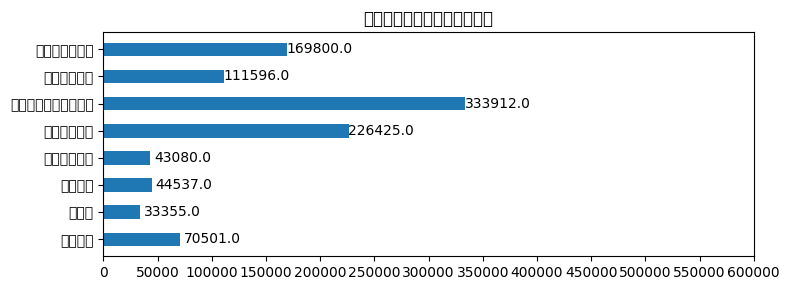

In [226]:
#可视化展示:不同类型用户消费总金额分析
plt.rcParams['font.family']=['Arial Unicode MS']
plt.figure(figsize=(8,3),dpi=100)
y=mon['消费总金额']
x=mon['用户类型']

plt.barh(x,height=0.5,width=y)
plt.title('不同类型用户消费总金额对比')
for x,y in enumerate(y):
    plt.text(y+30000,x,np.round(y),ha='center',va='center',fontsize=10)
plt.xticks(np.arange(0,600001,50000))
plt.tight_layout()
plt.savefig('不同类型用户消费总金额对比',dpi=300)


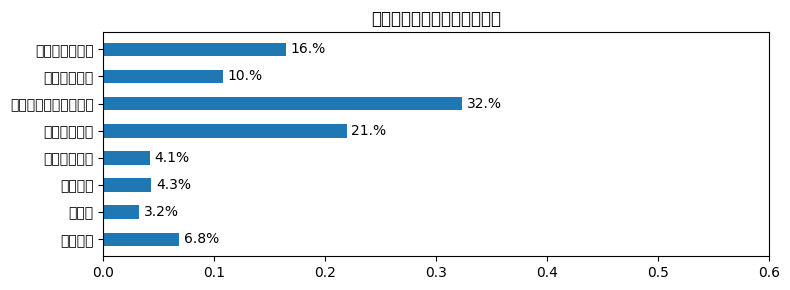

In [229]:
#可视化展示:不同类型用户消费金额占比分析
plt.rcParams['font.family']=['Arial Unicode MS']
plt.figure(figsize=(8,3),dpi=100)
y=mon['消费占比']
x=mon['用户类型']

plt.barh(x,height=0.5,width=y)
plt.title('不同类型用户消费总金额对比')
for x,y in enumerate(y):
    plt.text(y+0.02,x,str(y*100)[:3]+'%',ha='center',va='center',fontsize=10)
plt.xticks(np.arange(0,0.7,0.1))
plt.tight_layout()
plt.savefig('不同类型用户消费金额占比对比',dpi=300)

由上述图形可知：

重要价值客户人数占比虽小，仅为 15%，但其创造的经济价值却是最高的，占当月总收入的 32%；故针对这类用户的营销其实是最有效且最高效的

由上述图形可知：

重要价值客户人数占比虽小，仅为 15%，但其创造的经济价值却是最高的，占当月总收入的 45%；故针对这类用户的营销其实是最有效且最高效的。

但我们光对比两张图无法得出明显的结论，下面绘制各用户群人均消费金额图表

3、不同用户类型人均消费金额情况：

先添加【平均消费金额】字段：

In [231]:
rfm2=pd.merge(count,mon,left_on='用户类型',right_on='用户类型',how='inner')
rfm2['平均消费金额']=rfm2['消费总金额']/rfm2['人数']

In [232]:
rfm2

,用户类型,人数,人数占比,消费总金额,消费占比,平均消费金额
0,高消费挽回客户,2615,0.264542,169799.54,0.164342,64.932902
1,频次深耕客户,1711,0.173091,111596.01,0.108010,65.222683
2,流失客户,1630,0.164896,44537.06,0.043106,27.323350
3,新客户,1157,0.117046,33355.39,0.032283,28.829205
4,重要价值流失预警客户,1032,0.104401,333911.56,0.323180,323.557713
5,重要价值客户,892,0.090238,226424.85,0.219148,253.839518
6,一般客户,471,0.047648,70500.87,0.068235,149.683376
7,消费潜力客户,377,0.038139,43080.20,0.041696,114.271088


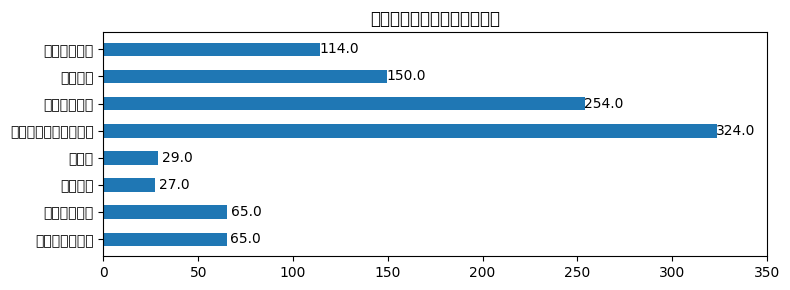

In [236]:
#可视化展示:不同类型用户平均消费金额分析
plt.rcParams['font.family']=['Arial Unicode MS']
plt.figure(figsize=(8,3),dpi=100)
y=rfm2['平均消费金额']
x=rfm2['用户类型']

plt.barh(x,height=0.5,width=y)
plt.title('不同类型用户消费总金额对比')
for x,y in enumerate(y):
    plt.text(y+10,x,np.round(y),ha='center',va='center',fontsize=10)
plt.xticks(np.arange(0,400,50))
plt.tight_layout()
plt.savefig('不同类型用户平均消费金额对比',dpi=300)


在此我们可以直观地看到，重要价值客户的人均贡献金额达到了 324 元，在所有客户群中是最为突出的，针对该类用户的营销策略也应着重进行。